# Experiment: Water Management Strategies: Water Treatment



In [1]:
import math
import os
import sys

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

from src.aquastat_utils import *

# Import AQUASTAT
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.
Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import scipy.stats as stats

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

### Check available Data for inconsistencies
There are multiple municipal wastewater variables. To check their consistencies we should check if they correspond to one another.

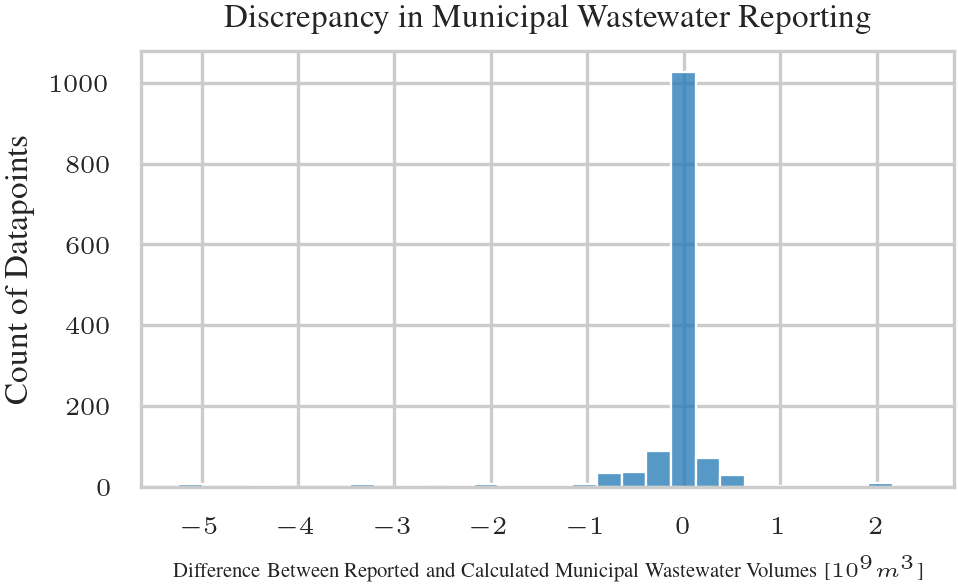

In [3]:
test_df = aquastat_df[['Country', 'Year', 'Treated municipal wastewater', 'Not treated municipal wastewater',
                       'Produced municipal wastewater']].dropna()

test_df['Difference'] = test_df['Produced municipal wastewater'] - (
            test_df['Treated municipal wastewater'] + test_df['Not treated municipal wastewater'])

sns.histplot(data=test_df, x='Difference', bins=30)
plt.title('Discrepancy in Municipal Wastewater Reporting')
plt.xlabel('Difference Between Reported and Calculated Municipal Wastewater Volumes [$10^9 m^3$]', fontsize='5')
plt.ylabel('Count of Datapoints')
plt.show()

For the overwhelming majority of the dataset the sum of treated and non-treated municipal wastewater is very close to the produced municipal wastewater.

### Fix Data

In [4]:
aquastat_df.loc[(aquastat_df['Country'] == 'Denmark') & (aquastat_df['Year'] >= 2011) & (aquastat_df['Year'] <= 2014), 'Produced municipal wastewater'] /= 1000

### Examine treated municiple water share

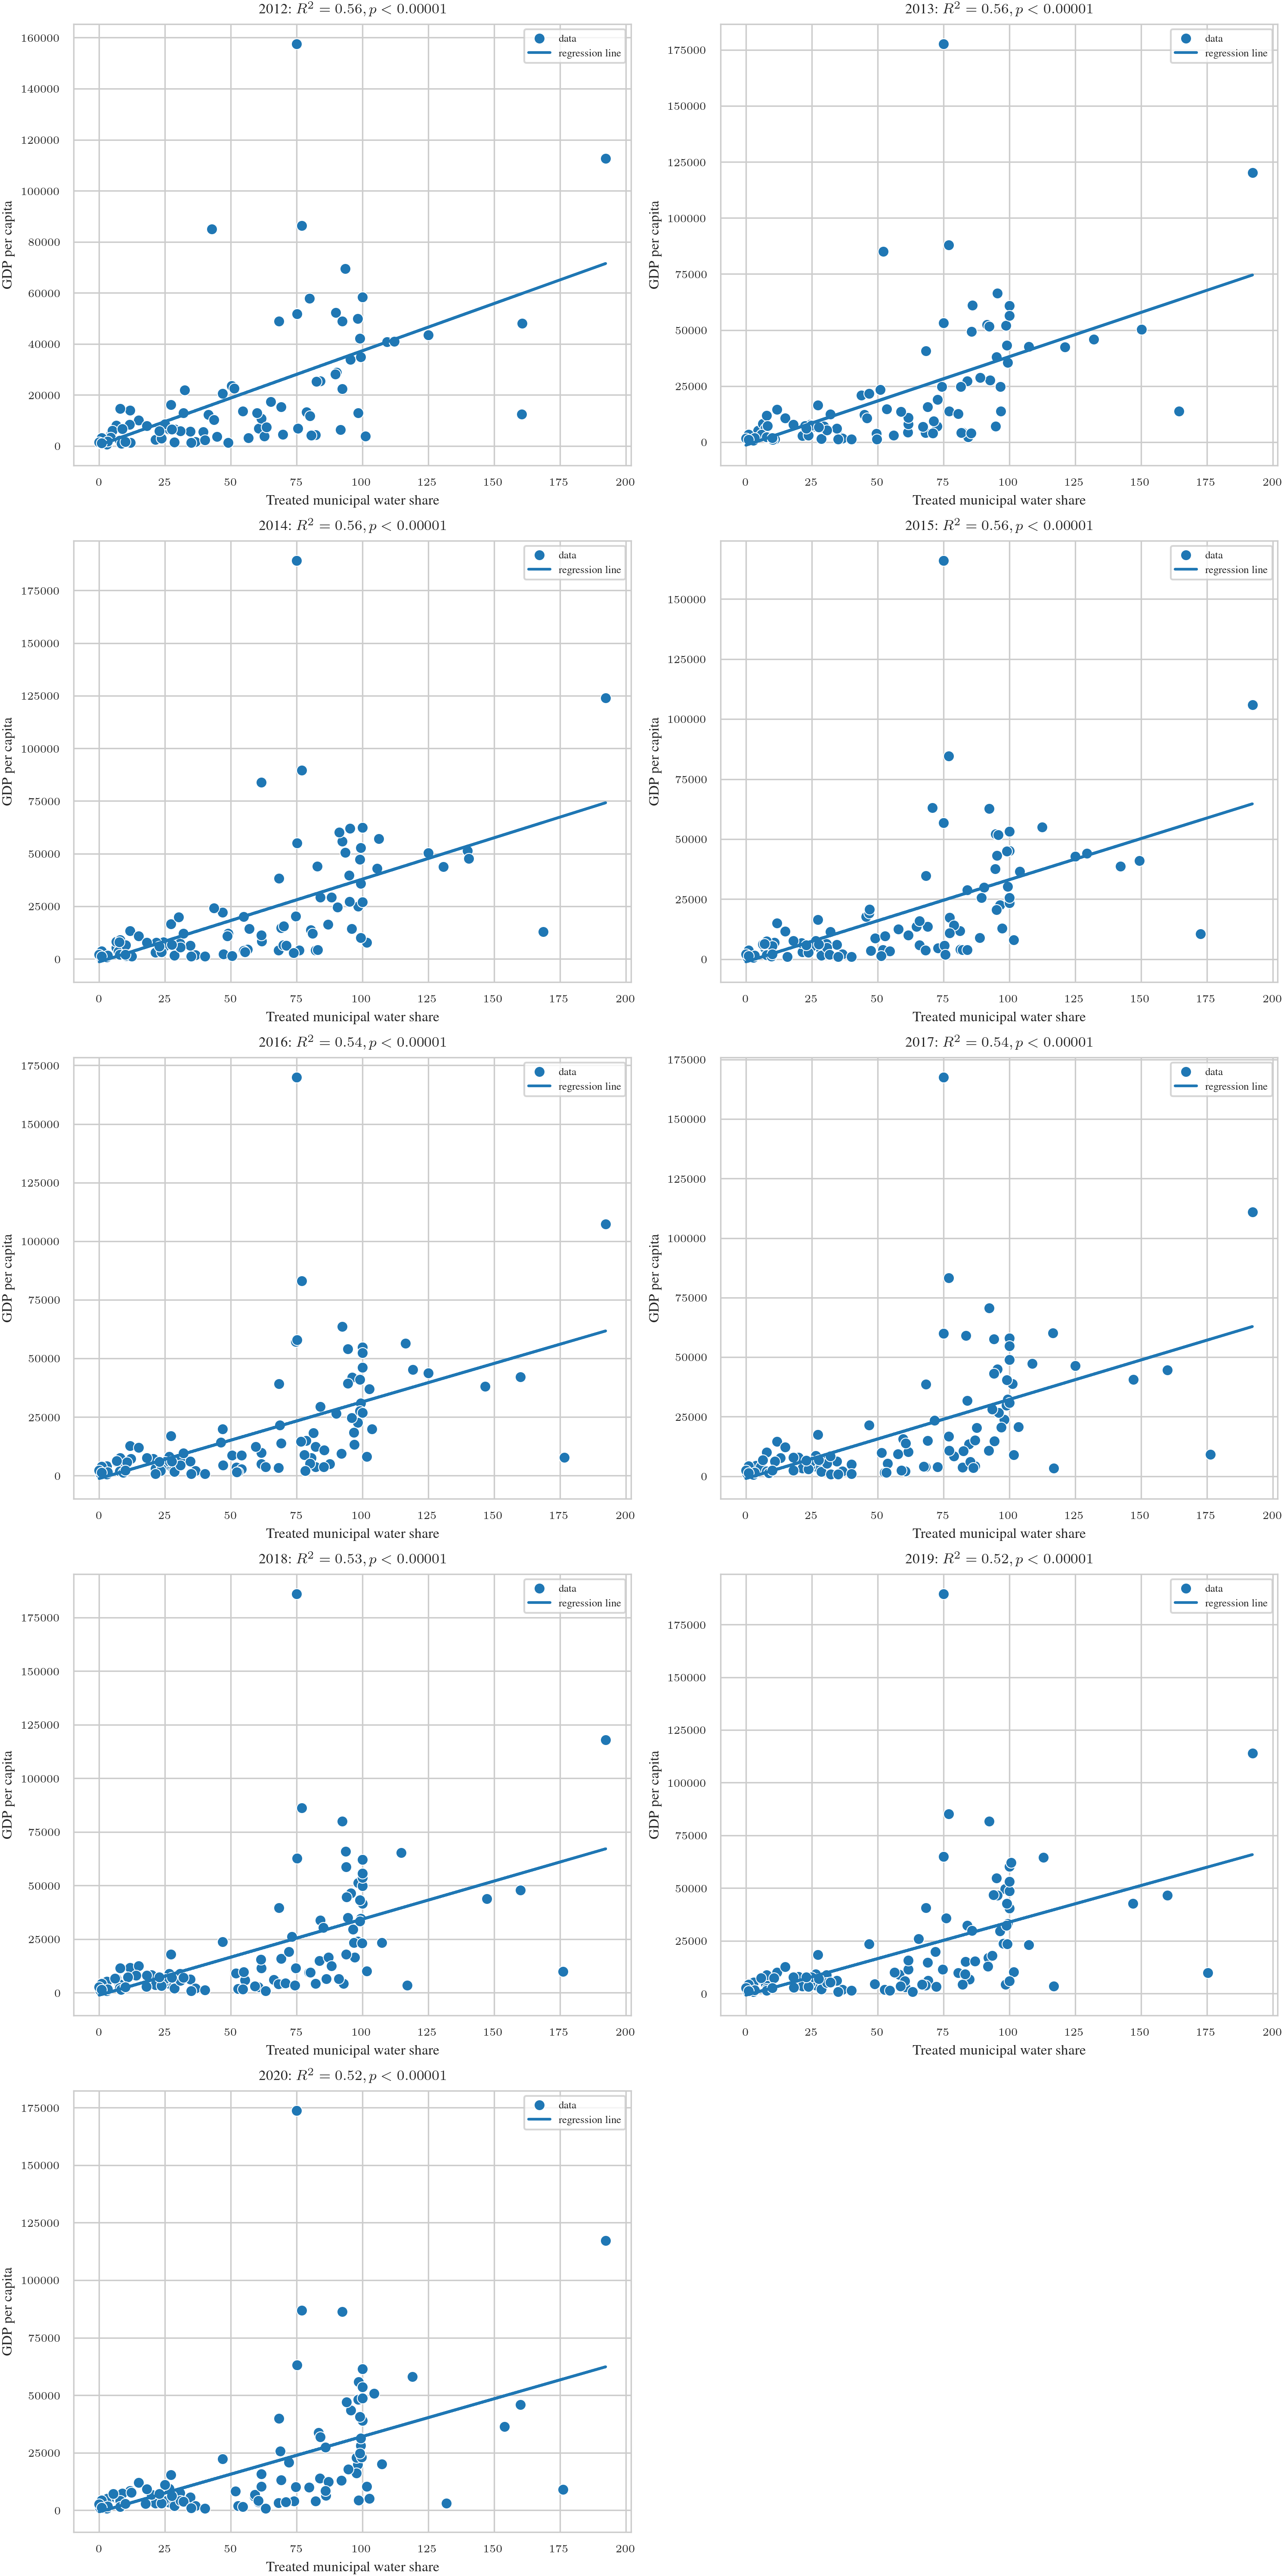

In [5]:
wastewater_df = aquastat_df[
    ['Country', 'Year', 'Treated municipal wastewater', 'Produced municipal wastewater']].dropna()
wastewater_df['Treated municipal water share'] = (wastewater_df['Treated municipal wastewater'] / wastewater_df[
    'Produced municipal wastewater']) * 100
wastewater_df = wastewater_df[wastewater_df['Treated municipal water share'] < 200]

regression_var = 'GDP per capita'
wastewater_df[regression_var] = aquastat_df[regression_var]
wastewater_df = wastewater_df.dropna()

start = 2012
years = wastewater_df[wastewater_df['Year'] >= 2012]['Year'].unique()
years.sort()
n = len(years)
width = min(2, n)
height = math.ceil(n / width)

fig, axes = plt.subplots(height, width, figsize=(5 * width, 4 * height))
for i, year in enumerate(years):
    ax = axes[i // width, i % width]
    data = wastewater_df[wastewater_df['Year'] == year]
    sns.scatterplot(
        ax=axes[i // width, i % width],
        data=data,
        x='Treated municipal water share',
        y=regression_var,
        label='data')

    x = data['Treated municipal water share'].values
    y = data[regression_var].values
    slope, intercept, r, p, _ = stats.linregress(x=x, y=y)
    ax.plot(x, slope * x + intercept, label='regression line')
    ax.legend()

    eq = '='
    if p < 0.00001:
        eq = '<'
        p = 0.00001

    ax.set_title(f'{year}: $R^2 = {r:.2f}, p {eq} {p:.5f}$')

for i in range(n, width * height):
    axes[i // width, i % width].axis('off')

### Plot water treatment

In [6]:
wastewater_df[wastewater_df['Country'] == 'Denmark']

Variable,Country,Year,Treated municipal wastewater,Produced municipal wastewater,Treated municipal water share,GDP per capita
2613,Denmark,2010,0.367594,0.500000,73.518800,57966.574651
2614,Denmark,2011,0.364477,0.364477,100.000000,61616.423638
2615,Denmark,2012,0.363830,0.363830,100.000000,58305.934680
2616,Denmark,2013,0.360852,0.360853,99.999723,60939.261344
2617,Denmark,2014,0.353667,0.353667,100.000000,62320.165407
2618,Denmark,2015,0.346720,0.346720,100.000000,53206.064106
2619,Denmark,2016,0.347714,0.347714,100.000000,54823.462778
2620,Denmark,2017,0.347714,0.347714,100.000000,57938.797728
2621,Denmark,2018,0.353462,0.353462,100.000000,62036.404698
2622,Denmark,2019,0.345172,0.345172,100.000000,60216.357595


Saving figure to fig/water_management/fig_world_map_Treated_municipal_water_share_2012.pdf ... Done!


(<Figure size 975x602.583 with 2 Axes>,
 <Axes: title={'center': 'Wastewater Treatment 2012'}>)

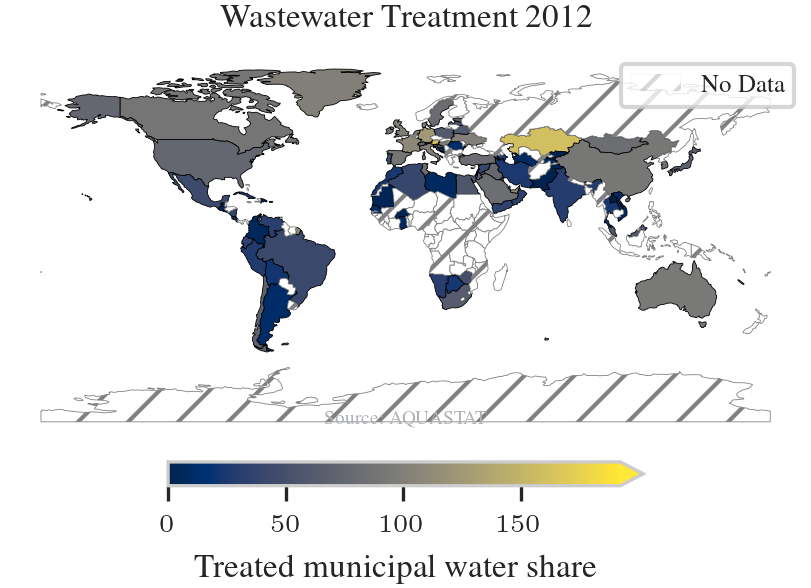

In [7]:
'''Plot water treatment for a given year.'''
from src.aquastat_plot import plot_world

year = 2012
plot_world(wastewater_df, year=year, variable='Treated municipal water share', title=f'Wastewater Treatment {year}', cmap='cividis')

/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/aquastat_plot.py:256: RuntimeWarning: invalid value encountered in scalar divide
  rate = ((y[-1] - y[0]) / y[0]) * 100


Saving figure to fig/water_management/fig_growth_rate_Treated_municipal_water_share.pdf ... Done!


(<Figure size 975x602.583 with 2 Axes>,
 [<Axes: title={'center': 'Growth of Wastewater Treatment (2012 - 2020)'}>])

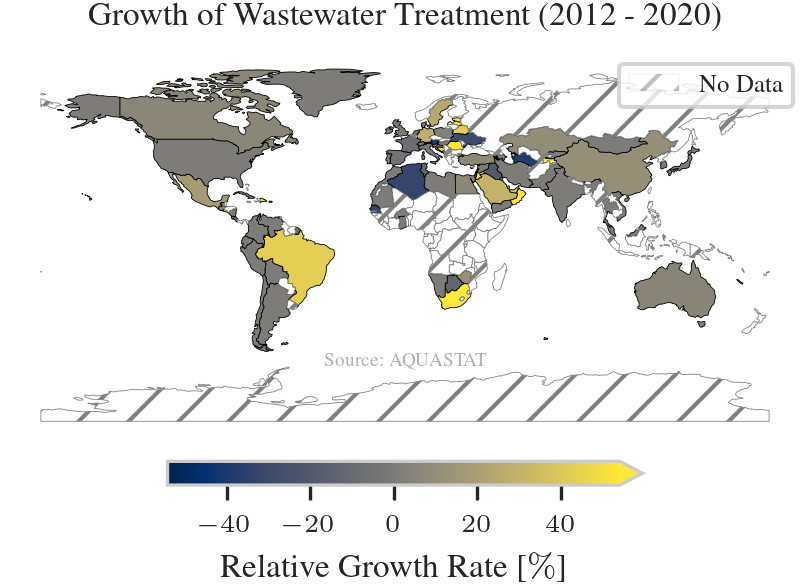

In [8]:
from src.aquastat_plot import plot_growth_rate
from src.utils import save_fig

share_df = wastewater_df[['Treated municipal water share', 'Country', 'Year']].dropna()
share_df = share_df.pivot(index='Year', columns='Country', values='Treated municipal water share')
share_df = share_df.loc[2012:2020].dropna(axis=1)
share_df = share_df.reset_index().melt(id_vars='Year', var_name='Country', value_name='Treated municipal water share')
plot_growth_rate(share_df, 'Treated municipal water share', title_vars='Wastewater Treatment')

### Check for connections to water stress

Saving figure to fig/water_management/fig_growth_rate_SDG_6.4.2._Water_Stress.pdf ... Done!


(<Figure size 975x602.583 with 2 Axes>,
 [<Axes: title={'center': 'Growth of Water Stress (2012 - 2020)'}>])

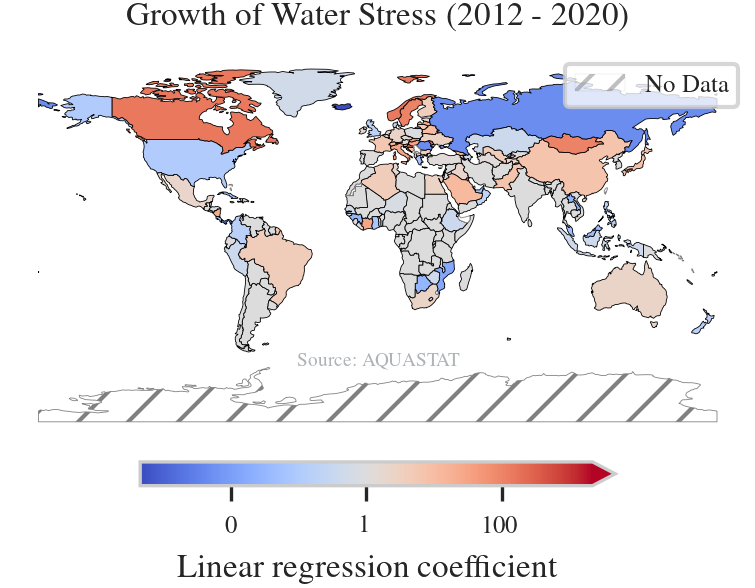

In [9]:
interesting_var = 'SDG 6.4.2. Water Stress'

stress_df = aquastat_df[['Country', 'Year', interesting_var]]
stress_df = stress_df.dropna()  # Drop rows with missing values
stress_df = stress_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

plot_growth_rate(
    stress_df, 
    'SDG 6.4.2. Water Stress',
    'coolwarm',
    'Water Stress',
    slope=True,
    log_scale=True
)

In [10]:
def l(x):
    if x < 0:
        y = -math.log10(-x)
    elif x == 0:
        y = 0
    else:
        y = math.log10(x)
    return y

Saving figure to fig/water_management/fig_world_map_Water_Stress_Log_2012.pdf ... Done!


(<Figure size 975x602.583 with 2 Axes>,
 <Axes: title={'center': 'Wastewater Treatment 2012'}>)

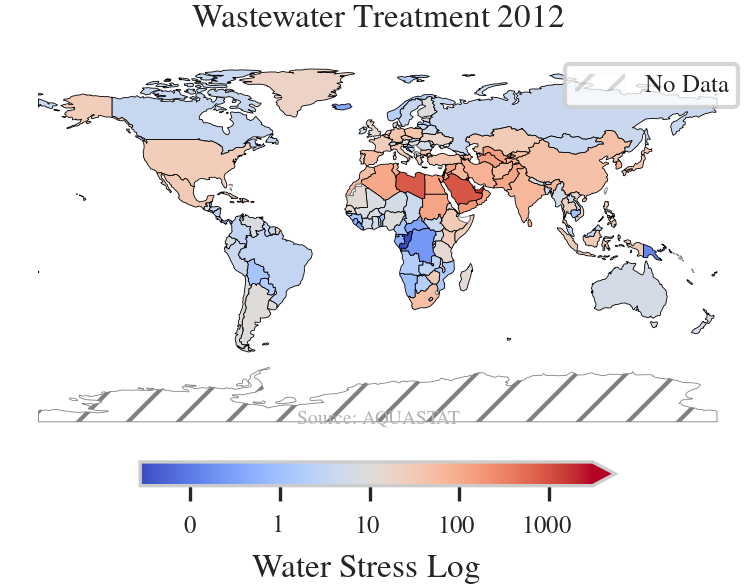

In [11]:
'''Plot water treatment for a given year.'''
stress_df['Water Stress Log'] = stress_df['SDG 6.4.2. Water Stress'].apply(l)

year = 2012
plot_world(stress_df, year=year, variable='Water Stress Log', title=f'Wastewater Treatment {year}', cmap='coolwarm', log_scale=True)